# Rupakoe : AI Deteksi Tipe Kulit Wajah

- No Dropout
- Image size : 300  
- No undersampling

# Import Library

In [1]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import gdown
import matplotlib.pyplot as plt

In [2]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
from sklearn.utils import resample

In [3]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import MobileNet, ResNet50, VGG16, MobileNetV2, EfficientNetV2B3
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# Data Preparation

## Data Loading

In [4]:
# Load data dari google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Download file dari Google Drive
file_id = "1up5yMQPHxkF_vxi0kmzkqdTB-kn6hVx4"
output = "skin_type_dataset.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

# Ekstrak ZIP
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("skin-type-dataset")  # folder hasil ekstraksi

Downloading...
From (original): https://drive.google.com/uc?id=1up5yMQPHxkF_vxi0kmzkqdTB-kn6hVx4
From (redirected): https://drive.google.com/uc?id=1up5yMQPHxkF_vxi0kmzkqdTB-kn6hVx4&confirm=t&uuid=bfe8ed04-7479-4105-8f8d-3fe300edc8c8
To: /content/skin_type_dataset.zip
100%|██████████| 82.6M/82.6M [00:01<00:00, 52.0MB/s]


In [6]:
dataset_path = "skin-type-dataset"
selected_classes = ['berminyak', 'kering', 'normal']
filtered_path = "filtered-skin-type-dataset"

# Hapus folder lama jika sudah ada
if os.path.exists(filtered_path):
    shutil.rmtree(filtered_path)

# Buat ulang folder filtered_path
os.makedirs(filtered_path, exist_ok=True)

# Untuk setiap split (train, valid, test)
for split in ['train', 'valid', 'test']:
    split_src = os.path.join(dataset_path, split)
    split_dst = os.path.join(filtered_path, split)

    os.makedirs(split_dst, exist_ok=True)

    for class_name in selected_classes:
        src_class_dir = os.path.join(split_src, class_name)
        dst_class_dir = os.path.join(split_dst, class_name)

        # Cek apakah folder kelas ada
        if os.path.exists(src_class_dir):
            shutil.copytree(src_class_dir, dst_class_dir)

In [7]:
# Buat tabel path data dan labelnya
data_dir = '/content/filtered-skin-type-dataset'
filepaths = []
labels = []

## Buat Dataframe Gambar dan Label

In [8]:
import os
import pandas as pd

data_dir = '/content/filtered-skin-type-dataset'
filepaths = []
labels = []
splits = []

# Loop melalui folder split: train, valid, test
for split in ['train', 'valid', 'test']:
    split_path = os.path.join(data_dir, split)

    # Loop kelas dalam masing-masing split
    for label in os.listdir(split_path):
        class_path = os.path.join(split_path, label)

        # Loop semua file gambar dalam folder kelas
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)

            filepaths.append(fpath)
            labels.append(label)
            splits.append(split)

# Buat DataFrame
df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels,
    'split': splits
})


In [9]:
# hitung jumlah label
df.head()

,filepath,label,split
0,/content/filtered-skin-type-dataset/train/norm...,normal,train
1,/content/filtered-skin-type-dataset/train/norm...,normal,train
2,/content/filtered-skin-type-dataset/train/norm...,normal,train
3,/content/filtered-skin-type-dataset/train/norm...,normal,train
4,/content/filtered-skin-type-dataset/train/norm...,normal,train


In [10]:
# Jumlah data : 13711 data gamba
df.shape

(3962, 3)

In [11]:
# Jumlah gambar pada tiap kelas
df['label'].value_counts()

,count
label,
berminyak,1803
normal,1124
kering,1035


## Data Visualization

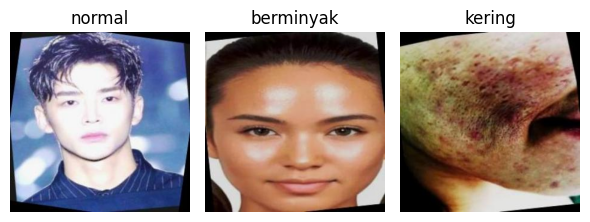

In [12]:
# Cek gambar pada dataset
# Ambil gambar pertama dari setiap kelas unik
unique_classes = list(set(labels))
selected_images = {}

for filepath, label in zip(filepaths, labels):
    if label not in selected_images:
        selected_images[label] = filepath
    if len(selected_images) == 10:
        break

# Tampilkan gambar
fig, axes = plt.subplots(1, 3, figsize=(6, 3))  # Grid 2x5
for ax, (label, img_path) in zip(axes.flat, selected_images.items()):
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")
plt.tight_layout()
plt.show()

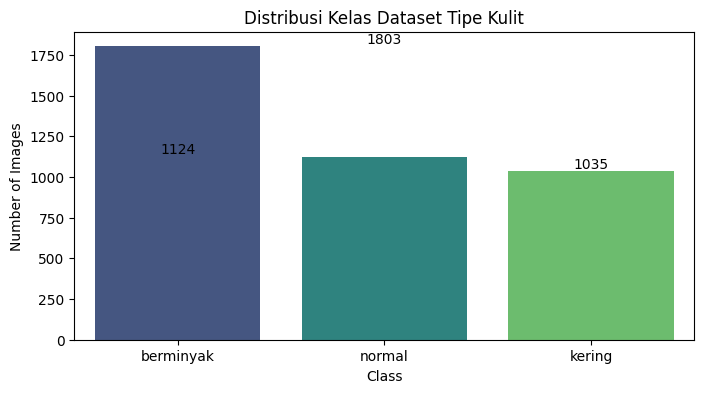

In [13]:
import seaborn as sns
from collections import Counter

class_counts = Counter(labels)
df_counts = pd.DataFrame(class_counts.items(), columns=["Class", "Count"])
df_counts = df_counts.sort_values(by="Count", ascending=False)

plt.figure(figsize=(8, 4))
barplot = sns.barplot(x="Class", y="Count", data=df_counts, palette='viridis')
for index, row in df_counts.iterrows():
    barplot.text(x=index, y=row["Count"] + 1, s=str(row["Count"]),
                 ha='center', va='bottom', fontsize=10)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Distribusi Kelas Dataset Tipe Kulit")
plt.show()

In [14]:
# Menyimpan ukuran (width, height)
widths = []
heights = []
df_img_resolution = df.copy()

# Loop semua baris dataframe
for path in df_img_resolution['filepath']:
    with Image.open(path) as img:
        width, height = img.size
        widths.append(width)
        heights.append(height)

# Tambahkan ke DataFrame
df_img_resolution['width'] = widths
df_img_resolution['height'] = heights

# Hitung rata-rata width dan height untuk setiap split
avg_resolution = df_img_resolution.groupby('split')[['width', 'height']].mean().round(2)
avg_resolution


,width,height
split,,
test,300.0,300.0
train,300.0,300.0
valid,300.0,300.0


# Data Preprocessing

## Split Dataset

In [15]:
# Split dataset menjadi menjadi dataframe train, val, dan test
train_df = df[df['split'] == 'train'].reset_index(drop=True)
val_df = df[df['split'] == 'valid'].reset_index(drop=True)
test_df  = df[df['split'] == 'test'].reset_index(drop=True)

# Cek jumlah data tiap split
print(f"Train size: {len(train_df)}")
print(f"Valid size: {len(val_df)}")
print(f"Test size:  {len(test_df)}")

Train size: 3076
Valid size: 786
Test size:  100


In [16]:
# Cek jumlah citra per kelas
print("Jumlah gambar per kelas di Training Set:")
print(train_df['label'].value_counts())

print("\nJumlah gambar per kelas di Validation Set:")
print(val_df['label'].value_counts())

print("\nJumlah gambar per kelas di Test Set:")
print(test_df['label'].value_counts())

Jumlah gambar per kelas di Training Set:
label
berminyak    1404
normal        865
kering        807
Name: count, dtype: int64

Jumlah gambar per kelas di Validation Set:
label
berminyak    349
normal       233
kering       204
Name: count, dtype: int64

Jumlah gambar per kelas di Test Set:
label
berminyak    50
normal       26
kering       24
Name: count, dtype: int64


In [17]:
# Cek train df
train_df.head()

,filepath,label,split
0,/content/filtered-skin-type-dataset/train/norm...,normal,train
1,/content/filtered-skin-type-dataset/train/norm...,normal,train
2,/content/filtered-skin-type-dataset/train/norm...,normal,train
3,/content/filtered-skin-type-dataset/train/norm...,normal,train
4,/content/filtered-skin-type-dataset/train/norm...,normal,train


In [18]:
# Cek val df
val_df.head()

,filepath,label,split
0,/content/filtered-skin-type-dataset/valid/norm...,normal,valid
1,/content/filtered-skin-type-dataset/valid/norm...,normal,valid
2,/content/filtered-skin-type-dataset/valid/norm...,normal,valid
3,/content/filtered-skin-type-dataset/valid/norm...,normal,valid
4,/content/filtered-skin-type-dataset/valid/norm...,normal,valid


In [19]:
# Cek test df
test_df.head()

,filepath,label,split
0,/content/filtered-skin-type-dataset/test/norma...,normal,test
1,/content/filtered-skin-type-dataset/test/norma...,normal,test
2,/content/filtered-skin-type-dataset/test/norma...,normal,test
3,/content/filtered-skin-type-dataset/test/norma...,normal,test
4,/content/filtered-skin-type-dataset/test/norma...,normal,test


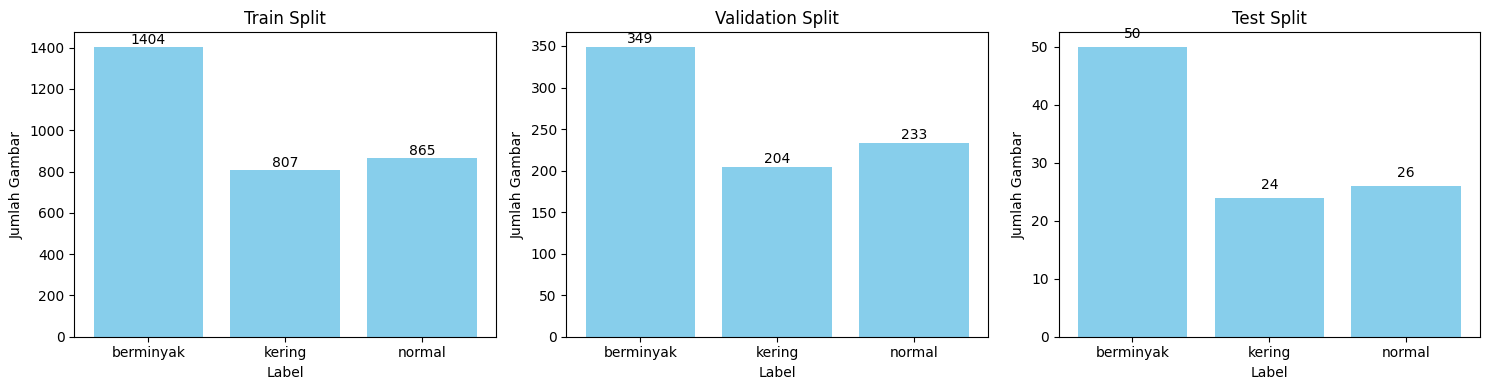

In [20]:
# Plot distribusi data
splits = [train_df, val_df, test_df]
titles = ['Train', 'Validation', 'Test']
# Buat figure dan 3 axes (1 baris, 3 kolom)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, df_split, title in zip(axes, splits, titles):
    label_counts = df_split['label'].value_counts().sort_index()
    bars = ax.bar(label_counts.index, label_counts.values, color='skyblue')
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval),
                ha='center', va='bottom', fontsize=10)
    ax.set_title(f'{title} Split')
    ax.set_xlabel('Label')
    ax.set_ylabel('Jumlah Gambar')

plt.tight_layout()
plt.show()

## Normalisasi Piksel

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

## Image Resizing

In [23]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(300, 300),
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(300, 300),
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(300, 300),
    class_mode='categorical',
    shuffle=False
)

Found 3076 validated image filenames belonging to 3 classes.
Found 786 validated image filenames belonging to 3 classes.
Found 100 validated image filenames belonging to 3 classes.


# Modelling

## Membuat Callback

In [24]:
# Callback kustom untuk menghentikan training jika val_accuracy & accuracy > 95%
class AccuracyOnTarget(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if logs.get('val_accuracy') > 0.95 and logs.get('accuracy') > 0.95:
            print('\n🎯 Val Accuracy dan Training Accuracy telah mencapai > 95%! Training dihentikan.')
            self.model.stop_training = True

# Subclass dari EarlyStopping untuk menambahkan pesan saat training dihentikan
class EarlyStoppingWithMessage(EarlyStopping):
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"\n🛑 Training dihentikan oleh EarlyStopping pada epoch {self.stopped_epoch + 1}. "
                  f"Val accuracy tidak membaik selama {self.patience} epoch.")

# Fungsi untuk mengembalikan semua callback yang dibutuhkan
def get_callbacks():
    accuracy_callback = AccuracyOnTarget()
    early_stop_callback = EarlyStoppingWithMessage(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True
    )

    return [accuracy_callback, early_stop_callback]


## CNN

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization

model_1 = Sequential()

model_1.add(Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(300, 300, 3)))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model_1.add(BatchNormalization())
model_1.add(MaxPooling2D(pool_size=(2,2)))

model_1.add(GlobalAveragePooling2D())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(len(train_generator.class_indices), activation='softmax'))  # Output sesuai jumlah kelas

model_1.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 300, 300, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 300, 300, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 150, 150, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,731 (631.76 KB)

 Trainable params: 161,283 (630.01 KB)

 Non-trainable params: 448 (1.75 KB)

In [29]:
model_1.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [30]:
# Train the model
history_1 = model_1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    batch_size=32,
    callbacks=get_callbacks()
)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 27s 225ms/step - accuracy: 0.5095 - loss: 1.0272 - val_accuracy: 0.2595 - val_loss: 1.3039
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 30s 142ms/step - accuracy: 0.5854 - loss: 0.9097 - val_accuracy: 0.2595 - val_loss: 1.6336
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 0.6112 - loss: 0.8716 - val_accuracy: 0.2595 - val_loss: 1.7649
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 0.6318 - loss: 0.8392 - val_accuracy: 0.4542 - val_loss: 1.2605
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.6415 - loss: 0.7944 - val_accuracy: 0.4822 - val_loss: 1.1121
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 0.6751 - loss: 0.7658 - val_accuracy: 0.5636 - val_loss: 0.9326
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 227ms/step - accuracy: 0.7088 - loss: 0.6948 - val_accuracy: 0.3715 - val_loss: 1.7809
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 0.7323 - loss: 0.6424 - 

In [31]:
# Saved the model
# Keras
model_1.save("cnn_skin_type_model.keras")
# Save to drive
model_1.save('/content/drive/MyDrive/cnn_skin_type_model.keras')

In [32]:
# Save history
import json
# Saat selesai training
with open('cnn_history.json', 'w') as f:
    json.dump(history_1.history, f)
with open('/content/drive/MyDrive/cnn_history.json', 'w') as f:
    json.dump(history_1.history, f)

## ResNet50

In [61]:
# Load ResNet50 tanpa top (fully connected layers)
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

# Freeze semua layer pretrained
base_model_resnet50.trainable = False

# Tambahkan head klasifikasi
x = base_model_resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model_2 = Model(inputs=base_model_resnet50.input, outputs=predictions)
model_2.summary()

Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 306, 306,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 150, 150,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 150, 150,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 150, 150,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 152, 152,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 75, 75,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 75, 75,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 75, 75,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 75, 75,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 75, 75,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 75, 75,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 75, 75,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 75, 75,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 75, 75,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 75, 75,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 75, 75,    │      1,024 │ conv2_block1_3_c

 Total params: 23,719,043 (90.48 MB)

 Trainable params: 131,331 (513.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [62]:
model_2.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [63]:
# Train the model
history_2 = model_2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    batch_size=32,
    callbacks=get_callbacks()
)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 372ms/step - accuracy: 0.4055 - loss: 1.1326 - val_accuracy: 0.4822 - val_loss: 1.1015
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 195ms/step - accuracy: 0.4627 - loss: 1.0554 - val_accuracy: 0.4478 - val_loss: 1.0531
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - accuracy: 0.4743 - loss: 1.0433 - val_accuracy: 0.4618 - val_loss: 1.0190
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - accuracy: 0.5039 - loss: 1.0013 - val_accuracy: 0.4809 - val_loss: 0.9955
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step - accuracy: 0.4870 - loss: 1.0269 - val_accuracy: 0.5420 - val_loss: 0.9889
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - accuracy: 0.5298 - loss: 0.9787 - val_accuracy: 0.4924 - val_loss: 0.9905
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 20s 209ms/step - accuracy: 0.5113 - loss: 1.0098 - val_accuracy: 0.5522 - val_loss: 0.9649
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 200ms/step - accuracy: 0.5215 - loss: 1.0038 - 

In [64]:
# Saved the model
# Keras
model_2.save("resnet50_skin_type_model.keras")
# Save to drive
model_2.save('/content/drive/MyDrive/resnet50_skin_type_model.keras')

In [65]:
# Save history
with open('restnet50_history.json', 'w') as f:
    json.dump(history_2.history, f)
with open('/content/drive/MyDrive/restnet50_history.json', 'w') as f:
    json.dump(history_2.history, f)

## MobileNetV2

In [80]:
# Load base model MobileNetV2 pretrained dari ImageNet
base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(300, 300, 3))
base_model_mobilenetv2.trainable = False

# Tambahkan head klasifikasi
x = base_model_mobilenetv2.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Bentuk model akhir
model_3 = Model(inputs=base_model_mobilenetv2.input, outputs=predictions)

model_3.summary()


<ipython-input-80-7a4f876fb732>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(300, 300, 3))


Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 150, 150,  │        864 │ input_layer_9[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 150, 150,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 150, 150,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 150, 150,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 150, 150,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 150, 150,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 150, 150,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 150, 150,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 150, 150,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 150, 150,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 150, 150,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 151, 151,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 75, 75,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 75, 75,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 75, 75,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 75, 75,    │      2,304 │ block_1_depthwis

 Total params: 2,340,163 (8.93 MB)

 Trainable params: 82,179 (321.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [81]:
# Compile model
model_3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [82]:
# Train the model
history_3 = model_3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    batch_size=32,
    callbacks=get_callbacks()
)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 32s 253ms/step - accuracy: 0.6797 - loss: 0.7230 - val_accuracy: 0.8092 - val_loss: 0.4648
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 139ms/step - accuracy: 0.8800 - loss: 0.3113 - val_accuracy: 0.8855 - val_loss: 0.2875
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.9297 - loss: 0.2247 - val_accuracy: 0.9186 - val_loss: 0.2192
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 0.9561 - loss: 0.1460 - val_accuracy: 0.9249 - val_loss: 0.2056
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.9693 - loss: 0.1111 - val_accuracy: 0.9364 - val_loss: 0.1668
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9822 - loss: 0.0851
🎯 Val Accuracy dan Training Accuracy telah mencapai > 95%! Training dihentikan.
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 0.9821 - loss: 0.0850 - val_accuracy: 0.9542 - val_loss: 0.1393


In [83]:
# Saved the model
# Keras
model_3.save("mobilenetv2_skin_type_model.keras")
# Save to drive
model_3.save('/content/drive/MyDrive/mobilenetv2_skin_type_model.keras')

In [84]:
# Save history
with open('mobilenetv2_history.json', 'w') as f:
    json.dump(history_3.history, f)
with open('/content/drive/MyDrive/mobilenetv2_history.json', 'w') as f:
    json.dump(history_3.history, f)

## EfficientNetV2B3

In [66]:
# Load base model EfficientNetB3 pretrained dari ImageNet
base_model_efficientnetb3 = EfficientNetV2B3(include_top=False, weights='imagenet', input_shape=(300, 300, 3))
base_model_efficientnetb3.trainable = False

# Tambahkan head klasifikasi
x = base_model_efficientnetb3.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Bentuk model akhir
model_4 = Model(inputs=base_model_efficientnetb3.input, outputs=predictions)

model_4.summary()


52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer_7[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ normalization[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │      5,760 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 150, 150,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 150, 150,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 150, 150,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 150, 150,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 150, 150,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 150, 150,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 150, 150,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 75, 75,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 75, 75,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 75, 75,    │          0 │ block2a_expand_b

 Total params: 13,029,185 (49.70 MB)

 Trainable params: 98,563 (385.01 KB)

 Non-trainable params: 12,930,622 (49.33 MB)

In [67]:
# Compile model
model_4.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [68]:
# Train the model
history_4 = model_4.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    batch_size=32,
    callbacks=get_callbacks()
)

Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 89s 504ms/step - accuracy: 0.4199 - loss: 1.0894 - val_accuracy: 0.4440 - val_loss: 1.0915
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.4608 - loss: 1.0725 - val_accuracy: 0.4440 - val_loss: 1.0752
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.4490 - loss: 1.0733 - val_accuracy: 0.4440 - val_loss: 1.0701
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.4478 - loss: 1.0685 - val_accuracy: 0.4440 - val_loss: 1.0760
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.4501 - loss: 1.0709 - val_accuracy: 0.4440 - val_loss: 1.0736
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.4581 - loss: 1.0685 - val_accuracy: 0.4440 - val_loss: 1.0714
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.4611 - loss: 1.0681 - val_accuracy: 0.4440 - val_loss: 1.0717
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.4569 - loss: 1.0686 - 

In [ ]:
# Saved the model
# Keras
model_4.save("efficientnetb3_skin_type_model.keras")
# Save to drive
model_4.save('/content/drive/MyDrive/efficientnetb3_skin_type_model.keras')

In [69]:
# Save history
with open('efficientnetb3_history.json', 'w') as f:
    json.dump(history_4.history, f)
with open('/content/drive/MyDrive/efficientnetb3_history.json', 'w') as f:
    json.dump(history_4.history, f)

## VGG16

In [70]:
# Load base model vgg16 pretrained
base_model_vgg16 =VGG16(
  include_top = False,
  weights='imagenet',
  input_tensor = tf.keras.layers.Input((300, 300, 3)),
)

base_model_vgg16.trainable = False

# Tambahkan head klasifikasi
x = base_model_vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Bentuk model akhir
model_5 = Model(inputs=base_model_vgg16.input, outputs=predictions)

model_5.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 300, 300, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 300, 300, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 150, 150, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 150, 150, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 150, 150, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 75, 75, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 75, 75, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 75, 75, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 37, 37, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 37, 37, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 37, 37, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 18, 18, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,747,715 (56.26 MB)

 Trainable params: 33,027 (129.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [71]:
# Compile model
model_5.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [72]:
# Train the model
history_5 = model_5.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    batch_size=32,
    callbacks=get_callbacks()
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1753']
Received: inputs=Tensor(shape=(None, 300, 300, 3))
  warnings.warn(msg)


97/97 ━━━━━━━━━━━━━━━━━━━━ 91s 688ms/step - accuracy: 0.4915 - loss: 1.0007 - val_accuracy: 0.6667 - val_loss: 0.8186
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 441ms/step - accuracy: 0.6479 - loss: 0.8070 - val_accuracy: 0.7048 - val_loss: 0.7303
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 441ms/step - accuracy: 0.6898 - loss: 0.7277 - val_accuracy: 0.6985 - val_loss: 0.6842
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 441ms/step - accuracy: 0.7230 - loss: 0.6754 - val_accuracy: 0.7303 - val_loss: 0.6382
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 461ms/step - accuracy: 0.7373 - loss: 0.6336 - val_accuracy: 0.7506 - val_loss: 0.6038
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 443ms/step - accuracy: 0.7477 - loss: 0.5968 - val_accuracy: 0.7583 - val_loss: 0.6082
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 83s 451ms/step - accuracy: 0.7622 - loss: 0.5602 - val_accuracy: 0.7277 - val_loss: 0.6189
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 438ms/step - accuracy: 0.7981 - loss: 0.5231 - val_accuracy

In [73]:
# Saved the model
# Keras
model_5.save("vgg16_skin_type_model.keras")
# Save to drive
model_5.save('/content/drive/MyDrive/vgg16_skin_type_model.keras')

In [74]:
# Save history
with open('vgg16_history.json', 'w') as f:
    json.dump(history_5.history, f)
with open('/content/drive/MyDrive/vgg16_history.json', 'w') as f:
    json.dump(history_5.history, f)

## Bandingkan Performa Model

In [85]:
import pandas as pd

# Ambil nilai maksimal akurasi dan minimal loss dari tiap history
def summarize_history(history, model_name):
    acc = max(history.history['accuracy'])
    val_acc = max(history.history['val_accuracy'])
    loss = min(history.history['loss'])
    val_loss = min(history.history['val_loss'])

    return {
        'Model': model_name,
        'Train Accuracy': round(acc, 4),
        'Val Accuracy': round(val_acc, 4),
        'Train Loss': round(loss, 4),
        'Val Loss': round(val_loss, 4)
    }

# Ringkasan tiap model
summary_data = [
    summarize_history(history_1, 'CNN'),
    summarize_history(history_2, 'ResNet50'),
    summarize_history(history_3, 'MobileNetV2'),
    summarize_history(history_4, 'EfficientNetV2B3'),
    summarize_history(history_5, 'VGG16')
]

# Buat DataFrame
summary_df = pd.DataFrame(summary_data)
summary_df

,Model,Train Accuracy,Val Accuracy,Train Loss,Val Loss
0,CNN,0.9789,0.9606,0.0676,0.1359
1,ResNet50,0.5806,0.6298,0.9142,0.8954
2,MobileNetV2,0.9815,0.9542,0.0817,0.1393
3,EfficientNetV2B3,0.4568,0.4440,1.0675,1.0701
4,VGG16,0.9548,0.9160,0.1407,0.2247


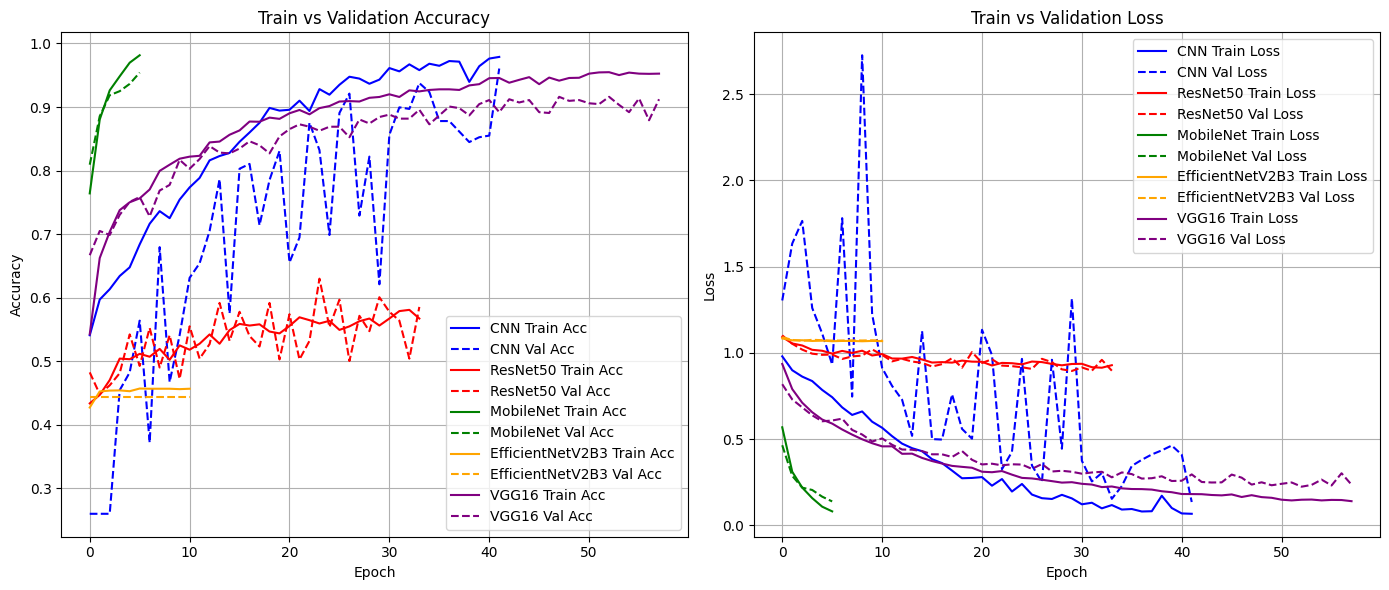

In [87]:
import matplotlib.pyplot as plt

def plot_training(histories, model_names):
    plt.figure(figsize=(14, 6))

    # Define colors for each model
    colors = ['blue', 'red', 'green', 'orange', 'purple']

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    for i, (history, name) in enumerate(zip(histories, model_names)):
        color = colors[i % len(colors)]
        plt.plot(history.history['accuracy'], label=f'{name} Train Acc', color=color, linestyle='-')
        plt.plot(history.history['val_accuracy'], label=f'{name} Val Acc', color=color, linestyle='--')
    plt.title('Train vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    for i, (history, name) in enumerate(zip(histories, model_names)):
        color = colors[i % len(colors)]
        plt.plot(history.history['loss'], label=f'{name} Train Loss', color=color, linestyle='-')
        plt.plot(history.history['val_loss'], label=f'{name} Val Loss', color=color, linestyle='--')
    plt.title('Train vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# ✅ Panggil fungsi dengan datamu
plot_training(
    histories=[history_1, history_2, history_3, history_4, history_5],
    model_names=['CNN', 'ResNet50', 'MobileNet', 'EfficientNetV2B3', 'VGG16']
)

# Testing Model

## Test dengan Data Testing

In [88]:
import pandas as pd

# Fungsi untuk meringkas hasil training dan testing
def summarize_model_performance(history, model, test_generator, model_name):
    # Hasil training/validation dari history
    train_acc = max(history.history['accuracy'])
    val_acc = max(history.history['val_accuracy'])
    train_loss = min(history.history['loss'])
    val_loss = min(history.history['val_loss'])

    # Evaluasi pada test set
    test_loss, test_acc = model.evaluate(test_generator, verbose=0)

    return {
        'Model': model_name,
        'Train Accuracy': round(train_acc, 4),
        'Val Accuracy': round(val_acc, 4),
        'Test Accuracy': round(test_acc, 4),
        'Train Loss': round(train_loss, 4),
        'Val Loss': round(val_loss, 4),
        'Test Loss': round(test_loss, 4)
    }

# Asumsikan Anda memiliki model-model yang sudah dilatih
# model_1, model_2, model_3, model_4, model_5

# Ringkasan semua model dengan hasil testing
summary_data = [
    summarize_model_performance(history_1, model_1, test_generator, 'CNN'),
    summarize_model_performance(history_2, model_2, test_generator, 'ResNet50'),
    summarize_model_performance(history_3, model_3, test_generator, 'MobileNetV2'),
    summarize_model_performance(history_4, model_4, test_generator, 'EfficientNetV2B3'),
    summarize_model_performance(history_5, model_5, test_generator, 'VGG16')
]

# Buat DataFrame
summary_df = pd.DataFrame(summary_data)

# Tampilkan hasil
print("Model Performance Comparison:")
print("="*80)
print(summary_df.to_string(index=False))

# Urutkan berdasarkan Test Accuracy (descending)
summary_df_sorted = summary_df.sort_values('Test Accuracy', ascending=False)
print("\n\nRanking by Test Accuracy:")
print("="*80)
print(summary_df_sorted.to_string(index=False))

# Tampilkan model terbaik
best_model_name = summary_df_sorted.iloc[0]['Model']
best_test_acc = summary_df_sorted.iloc[0]['Test Accuracy']
best_test_loss = summary_df_sorted.iloc[0]['Test Loss']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test Accuracy: {best_test_acc}")
print(f"   Test Loss: {best_test_loss}")

# Analisis overfitting (selisih train vs test accuracy)
summary_df['Overfitting (Train-Test)'] = round(summary_df['Train Accuracy'] - summary_df['Test Accuracy'], 4)
summary_df['Generalization (Val-Test)'] = round(summary_df['Val Accuracy'] - summary_df['Test Accuracy'], 4)

print(f"\n📊 Overfitting Analysis:")
print("="*80)
print(summary_df[['Model', 'Train Accuracy', 'Val Accuracy', 'Test Accuracy', 'Overfitting (Train-Test)', 'Generalization (Val-Test)']].to_string(index=False))

# # Return DataFrame untuk penggunaan selanjutnya
# summary_df

Model Performance Comparison:
           Model  Train Accuracy  Val Accuracy  Test Accuracy  Train Loss  Val Loss  Test Loss
             CNN          0.9789        0.9606           0.70      0.0676    0.1359     1.0384
        ResNet50          0.5806        0.6298           0.65      0.9142    0.8954     0.8627
     MobileNetV2          0.9815        0.9542           0.78      0.0817    0.1393     0.7323
EfficientNetV2B3          0.4568        0.4440           0.50      1.0675    1.0701     1.0499
           VGG16          0.9548        0.9160           0.75      0.1407    0.2247     1.1790


Ranking by Test Accuracy:
           Model  Train Accuracy  Val Accuracy  Test Accuracy  Train Loss  Val Loss  Test Loss
     MobileNetV2          0.9815        0.9542           0.78      0.0817    0.1393     0.7323
           VGG16          0.9548        0.9160           0.75      0.1407    0.2247     1.1790
             CNN          0.9789        0.9606           0.70      0.0676    0.1359    

4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step
              precision    recall  f1-score   support

   berminyak       0.76      0.84      0.80        50
      kering       0.85      0.71      0.77        24
      normal       0.76      0.73      0.75        26

    accuracy                           0.78       100
   macro avg       0.79      0.76      0.77       100
weighted avg       0.78      0.78      0.78       100



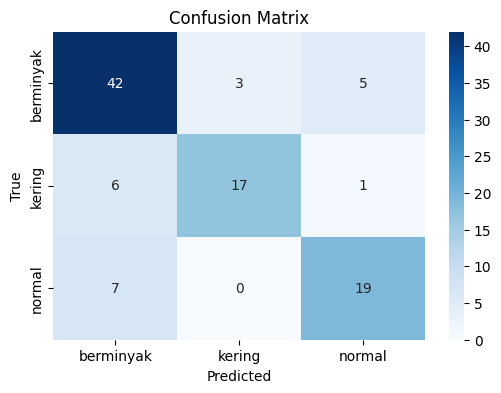

In [89]:
# Metrics model terbaik
y_pred_probs = model_3.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Laporan klasifikasi
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Inference Model

In [90]:
import numpy as np
import matplotlib.pyplot as plt

def predict_image(model, img_path, target_size=(300, 300), class_indices=None):
    # Load dan praproses gambar
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    prediction = model_3.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    confidence_score = prediction[0][predicted_class_index]

    if class_indices:
        labels = dict((v, k) for k, v in class_indices.items())
        predicted_label = labels[predicted_class_index]
    else:
        predicted_label = predicted_class_index

    # Tampilkan gambar & hasil
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence_score:.2%}")
    plt.show()
    return predicted_label, confidence_score

Saving images.jpg to images.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


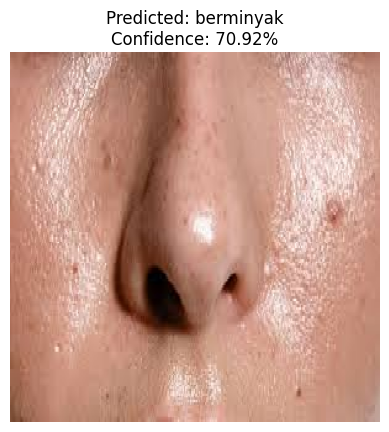

Predicted class: berminyak
Confidence score: 0.7092


In [91]:
from google.colab import files

uploaded = files.upload()

for filename in uploaded.keys():
    label, confidence = predict_image(
        model=model_3,
        img_path=filename,
        target_size=(300, 300),
        class_indices=test_generator.class_indices
    )
    print(f"Predicted class: {label}")
    print(f"Confidence score: {confidence:.4f}")
